In [ ]:
%%shell
# Inspred by https://colab.research.google.com/github/tensorflow/io/blob/master/docs/tutorials/postgresql.ipynb#scrollTo=YUj0878jPyz7
sudo apt-get -y -qq update
sudo apt-get -y -qq install postgresql-14
# Start postgresql server
sudo sed -i "s/port = 5432/port = 5433/g" /etc/postgresql/14/main/postgresql.conf
sudo service postgresql start
# Set password
sudo -u postgres psql -U postgres -c "ALTER USER postgres PASSWORD 'pyqrlew-db'"
# Install python packages
pip install -U pyqrlew graphviz

In [1]:
from pyqrlew.io import PostgreSQL
# Read data
db = PostgreSQL()
dataset = db.retail()

Error response from daemon: network with name qrlew-net already exists


In [2]:
dataset.relations()

[(['retail', 'features'], <Relation at 0x111c8d660>),
 (['retail', 'sales'], <Relation at 0x111c8d090>),
 (['retail', 'stores'], <Relation at 0x111c8d1b0>)]

In [3]:
print(dataset.relations()[0][1])

retail_features


# Utils

In [4]:
from IPython.display import display
import graphviz

def display_dot(dot_graph): 
    display(graphviz.Source(dot_graph))

In [5]:
MAGENTA_COLOR = '\033[35m'  
BLUE_COLOR = '\033[34m'
RESET_COLOR = '\033[0m'    

def print_query(query: str):
    keywords = ["SELECT", "AS", "GROUP BY", "LIMIT", "ORDER BY", "WHERE"]
    colored_query = query
    colored_query = colored_query.replace("WITH", "WITH\n ")
    colored_query = colored_query.replace(" SELECT", "\nSELECT")
    colored_query = colored_query.replace("),", "),\n ") 
    for word in keywords:
        colored_query = colored_query.replace(word, MAGENTA_COLOR + word + RESET_COLOR)
    colored_query = colored_query.replace("WITH", BLUE_COLOR + "WITH" + RESET_COLOR)
    print(colored_query)

print_query("WITH customers AS (SELECT * FROM table) SELECT * FROM customers WHERE age > 25")

WITH
  customers AS (SELECT * FROM table)
SELECT * FROM customers WHERE age > 25


In [ ]:
import json
from termcolor import colored

def to_json(str_schema: str):
    str_schema_to_json = str_schema.replace(" ", "")
    str_schema_to_json = str_schema_to_json.replace("{", '{"')
    str_schema_to_json = str_schema_to_json.replace(":", '":"')
    str_schema_to_json = str_schema_to_json.replace(",", '","')
    str_schema_to_json = str_schema_to_json.replace("}", '"}')
    return json.loads(str_schema_to_json)

def print_colored_json(json_data):
    formatted_json = json.dumps(json_data, indent=4)
    colored_json = highlight_keywords(formatted_json)
    print(colored_json)

def highlight_keywords(json_string):
    keywords = {
        "_PROTECTED_ENTITY_ID_": "red", 
        "_PROTECTED_ENTITY_WEIGHT_": "red", 
        "option": "yellow",
        "float": "blue", 
        "int": "blue"
    }
    for keyword, color in keywords.items():
        json_string = json_string.replace(keyword, colored(keyword, color))
    return json_string

str_schema = '{_PROTECTED_ENTITY_ID_: option(str), _PROTECTED_ENTITY_WEIGHT_: int[0 1469283], field_l_2l: float[0 2468395440]}'

print_colored_json(str_schema)


In [6]:
import pandas as pd
pd.DataFrame(db.execute("SELECT * FROM retail.features LIMIT 5"))

,id,store,date,temperature,fuel_price,cpi,unemployment,isholiday
0,1,1,2010-02-05,42.31,2.572,211.096358,8.106,False
1,2,1,2010-02-12,38.51,2.548,211.242170,8.106,True
2,3,1,2010-02-19,39.93,2.514,211.289143,8.106,False
3,4,1,2010-02-26,46.63,2.561,211.319643,8.106,False
4,5,1,2010-03-05,46.50,2.625,211.350143,8.106,False


In [7]:
import matplotlib.pyplot as plt

def plot_hist(true_value, data, query):
    plt.axvline(true_value, color='red', label="True")
    for e, d in data.items():
        plt.hist(d, bins=10, alpha=0.5, label = f"eps = {e}")
    plt.legend()
    plt.title(query)

In [8]:
N_RUNS = 100

def run(dataset, query, epsilons):
    data = {}
    str_pe = """
    {
    "protected_entity": [
        ["stores", [["store", "features", "store"]], "id"],
        ["features", [], "id"],
        ["sales", [], "id"]
    ]
    }
    """
    delta  = 1e-1
    relation = dataset.sql(query)
    for epsilon in epsilons: 
        dp_relation = relation.dp_compilation(
            dataset,
            str_pe,
            epsilon, 
            delta
        )
        dp_query = dp_relation.render()
        data[epsilon] = [
            execute_query(dp_query)["my_sum"][0] for _ in range(N_RUNS)
        ]
    return data

# Read Data

For this demo, we use the retail dataset containing 3 tables: 
 - features
 - sales
 - stores

We create a `Dataset` object from json files describing the tables and the columns (type, min, max, possible values .. ) of the dataset.

All the tables have been converted into `Relation` object: 

In [9]:
dataset.relations()

[(['retail', 'features'], <Relation at 0x1244565d0>),
 (['retail', 'sales'], <Relation at 0x124456540>),
 (['retail', 'stores'], <Relation at 0x1244565a0>)]

The corresponding `Relation` is given by: 

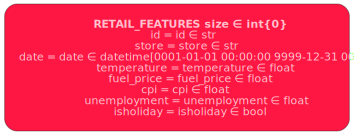

In [10]:
display_dot(dataset.relations()[0][1].dot())

A `Relation` contains information about the data types of each columns.

# Create a relation from an SQL query

We can create a `Relation` from a `Dataset` and an SQL query: 

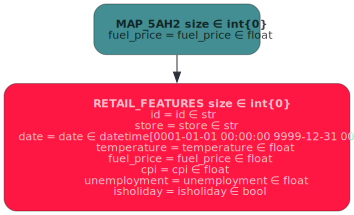

In [11]:
relation = dataset.sql('SELECT fuel_price As fuel_price FROM retail.features')
display_dot(relation.dot())

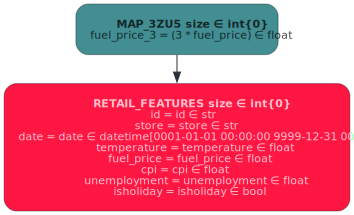

In [12]:
relation = dataset.sql('SELECT 3 * fuel_price AS fuel_price_3 FROM features')
display_dot(relation.dot())

The data types have been propagated without any query to the database. 


We can try with an aggregation: 

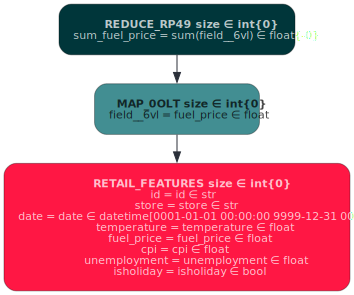

In [13]:
query = 'SELECT SUM(fuel_price) As sum_fuel_price FROM retail.features'
relation = dataset.sql(query)
display_dot(relation.dot())

Convert the `Relation` to an SQL query: 

In [14]:
#SELECT SUM(fuel_price) As sum_fuel_price FROM features
print_query(relation.render())

WITH
  map_0olt (field__6vl) AS (SELECT fuel_price AS field__6vl FROM retail.features),
  reduce_rp49 (sum_fuel_price) AS (SELECT sum(field__6vl) AS sum_fuel_price FROM map_0olt)
SELECT * FROM reduce_rp49


We send this query to the DB: 

In [15]:
res = db.eval(relation)
pd.DataFrame(res)

,sum_fuel_price
0,2965.117


Which gives the same results than the initial query: 

In [17]:
true_res = db.execute(query)
pd.DataFrame(true_res)

,sum_fuel_price
0,2965.117


# Protection

In [18]:
query

'SELECT SUM(fuel_price) As sum_fuel_price FROM retail.features'

The `protect` method transforms the initial `Relation` into a `Relation` where the protected entities are preserved, i.e. each row is owned by ony one individual. 

It inputs: 
- a `Dataset`
- a json string that contains the protected entity of each table:

In [20]:
str_pe = """
{
  "protected_entity": [
    ["retail_stores", [["store", "features", "store"]], "id"], 
    ["retail_features", [], "id"], 
    ["retail_sales", [], "id"]
  ]
}
"""

The protected entity of `features` is its column `id`:

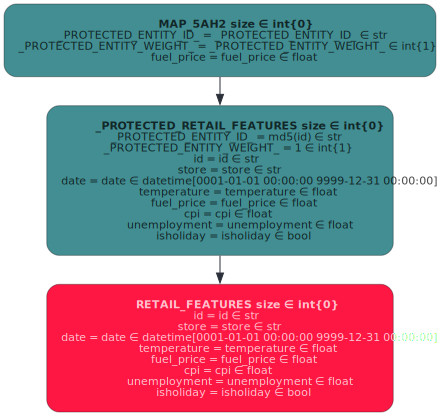

In [21]:
_relation = dataset.sql('SELECT fuel_price FROM retail.features')
_protected_relation = _relation.protect(
    dataset,
    str_pe
)
display_dot(_protected_relation.dot())

The protected entity of `stores` is the `id` column of `features`:

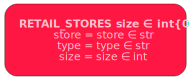

In [22]:
display_dot(dataset.relations()[2][1].dot())

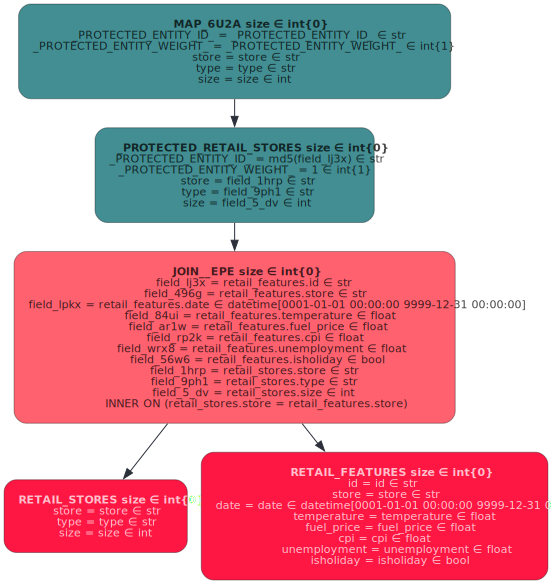

In [23]:
#protected entity: ["retail.stores", [["store", "retail.features", "store"]], "id"]
_relation = dataset.sql('SELECT * FROM retail.stores')
_protected_relation = _relation.protect(
    dataset,
    str_pe
)
display_dot(_protected_relation.dot())

We apply `protect`  to the `Relation` build from `SELECT SUM(fuel_price) As sum_fuel_price FROM features`:

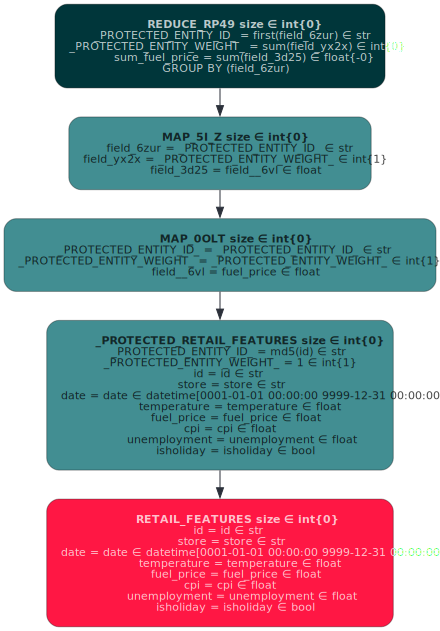

In [24]:
protected_relation = relation.protect(
    dataset,
    str_pe
)
display_dot(protected_relation.dot())

The protection reorganises the inital `Relation` so that the output `Relation` preserves the protected entity : **in the protected `Relation`, we are sure than each row is owned by only one individual.**

In our example, the initial `SUM` over the entire dataset has been replaced by a `SUM` groupped by the protected entities. 

In [26]:
print_query(protected_relation.render())

WITH
  _PROTECTED_retail_features (_PROTECTED_ENTITY_ID_, _PROTECTED_ENTITY_WEIGHT_, id, store, date, temperature, fuel_price, cpi, unemployment, isholiday) AS (SELECT md5(id) AS _PROTECTED_ENTITY_ID_, 1 AS _PROTECTED_ENTITY_WEIGHT_, id AS id, store AS store, date AS date, temperature AS temperature, fuel_price AS fuel_price, cpi AS cpi, unemployment AS unemployment, isholiday AS isholiday FROM retail.features),
  map_0olt (_PROTECTED_ENTITY_ID_, _PROTECTED_ENTITY_WEIGHT_, field__6vl) AS (SELECT _PROTECTED_ENTITY_ID_ AS _PROTECTED_ENTITY_ID_, _PROTECTED_ENTITY_WEIGHT_ AS _PROTECTED_ENTITY_WEIGHT_, fuel_price AS field__6vl FROM _PROTECTED_retail_features),
  map_5i_z (field_6zur, field_yx2x, field_3d25) AS (SELECT _PROTECTED_ENTITY_ID_ AS field_6zur, _PROTECTED_ENTITY_WEIGHT_ AS field_yx2x, field__6vl AS field_3d25 FROM map_0olt),
  reduce_rp49 (_PROTECTED_ENTITY_ID_, _PROTECTED_ENTITY_WEIGHT_, sum_fuel_price) AS (SELECT field_6zur AS _PROTECTED_ENTITY_ID_, sum(field_yx2x) AS _PROTECTED

In [27]:
pd.DataFrame(db.execute("SELECT * FROM retail.features"))

,id,store,date,temperature,fuel_price,cpi,unemployment,isholiday
0,1,1,2010-02-05,42.31,2.572,211.096358,8.106,False
1,2,1,2010-02-12,38.51,2.548,211.242170,8.106,True
2,3,1,2010-02-19,39.93,2.514,211.289143,8.106,False
3,4,1,2010-02-26,46.63,2.561,211.319643,8.106,False
4,5,1,2010-03-05,46.50,2.625,211.350143,8.106,False
...,...,...,...,...,...,...,...,...
905,906,5,2013-06-28,86.09,3.495,NaN,NaN,False
906,907,5,2013-07-05,82.06,3.422,NaN,NaN,False
907,908,5,2013-07-12,85.75,3.400,NaN,NaN,False
908,909,5,2013-07-19,79.73,3.556,NaN,NaN,False


In [28]:
print_query(protected_relation.render())

WITH
  _PROTECTED_retail_features (_PROTECTED_ENTITY_ID_, _PROTECTED_ENTITY_WEIGHT_, id, store, date, temperature, fuel_price, cpi, unemployment, isholiday) AS (SELECT md5(id) AS _PROTECTED_ENTITY_ID_, 1 AS _PROTECTED_ENTITY_WEIGHT_, id AS id, store AS store, date AS date, temperature AS temperature, fuel_price AS fuel_price, cpi AS cpi, unemployment AS unemployment, isholiday AS isholiday FROM retail.features),
  map_0olt (_PROTECTED_ENTITY_ID_, _PROTECTED_ENTITY_WEIGHT_, field__6vl) AS (SELECT _PROTECTED_ENTITY_ID_ AS _PROTECTED_ENTITY_ID_, _PROTECTED_ENTITY_WEIGHT_ AS _PROTECTED_ENTITY_WEIGHT_, fuel_price AS field__6vl FROM _PROTECTED_retail_features),
  map_5i_z (field_6zur, field_yx2x, field_3d25) AS (SELECT _PROTECTED_ENTITY_ID_ AS field_6zur, _PROTECTED_ENTITY_WEIGHT_ AS field_yx2x, field__6vl AS field_3d25 FROM map_0olt),
  reduce_rp49 (_PROTECTED_ENTITY_ID_, _PROTECTED_ENTITY_WEIGHT_, sum_fuel_price) AS (SELECT field_6zur AS _PROTECTED_ENTITY_ID_, sum(field_yx2x) AS _PROTECTED

In [30]:
pd.DataFrame(db.eval(protected_relation))

,_protected_entity_id_,_protected_entity_weight_,sum_fuel_price
0,d58072be2820e8682c0a27c0518e805e,1,3.682
1,5f93f983524def3dca464469d2cf9f3e,1,3.669
2,52720e003547c70561bf5e03b95aa99f,1,3.422
3,fccb3cdc9acc14a6e70a12f74560c026,1,3.610
4,9bf31c7ff062936a96d3c8bd1f8f2ff3,1,2.854
...,...,...,...
905,e555ebe0ce426f7f9b2bef0706315e0c,1,3.271
906,f340f1b1f65b6df5b5e3f94d95b11daf,1,3.488
907,a97da629b098b75c294dffdc3e463904,1,3.510
908,eed5af6add95a9a6f1252739b1ad8c24,1,3.480


In [31]:
pd.DataFrame(db.eval(protected_relation))

,_protected_entity_id_,_protected_entity_weight_,sum_fuel_price
0,d58072be2820e8682c0a27c0518e805e,1,3.682
1,5f93f983524def3dca464469d2cf9f3e,1,3.669
2,52720e003547c70561bf5e03b95aa99f,1,3.422
3,fccb3cdc9acc14a6e70a12f74560c026,1,3.610
4,9bf31c7ff062936a96d3c8bd1f8f2ff3,1,2.854
...,...,...,...
905,e555ebe0ce426f7f9b2bef0706315e0c,1,3.271
906,f340f1b1f65b6df5b5e3f94d95b11daf,1,3.488
907,a97da629b098b75c294dffdc3e463904,1,3.510
908,eed5af6add95a9a6f1252739b1ad8c24,1,3.480


We have one sum per protected entity. If we sum all the rows, we find the same results than with the initial query: 

In [34]:
#SELECT SUM(fuel_price) As sum_fuel_price FROM features
true_res = pd.DataFrame(db.execute(query))
summed_res = pd.DataFrame(db.eval(relation)).sum()

print(f"Initial query:                       sum_fuel_price: {true_res.iloc[0][0]}")
print(f"Sum over the all protected entities: sum_fuel_price: {summed_res[0]}")

Initial query:                       sum_fuel_price: 2965.1169999999997
Sum over the all protected entities: sum_fuel_price: 2965.1169999999997


# Dp compilation

With the `dp_compilation` method, we transform a query into its differentially private equivalent. 

It inputs: 
- the privacy parameters `epsilon` and `delta`
- a json string containing the protected entities of each table
- a `Dataset`
- an SQL query

In [49]:
str_pe = """
{
  "protected_entity": [
    ["retail_stores", [["store", "features", "store"]], "id"], 
    ["retail_features", [], "id"],
    ["retail_sales", [], "id"]
  ]
}
"""
epsilon = 1. 
delta  = 1e-3
relation = dataset.sql("SELECT SUM(fuel_price) AS my_sum FROM retail.features") 
dp_relation = relation.dp_compilation(
    dataset,
    str_pe,
    epsilon, 
    delta
)

thread '<unnamed>' panicked at 'attempt to divide by zero', /rustc/9eb3afe9ebe9c7d2b84b71002d44f4a0edac95e0/library/core/src/num/mod.rs:257:5


PanicException: attempt to divide by zero

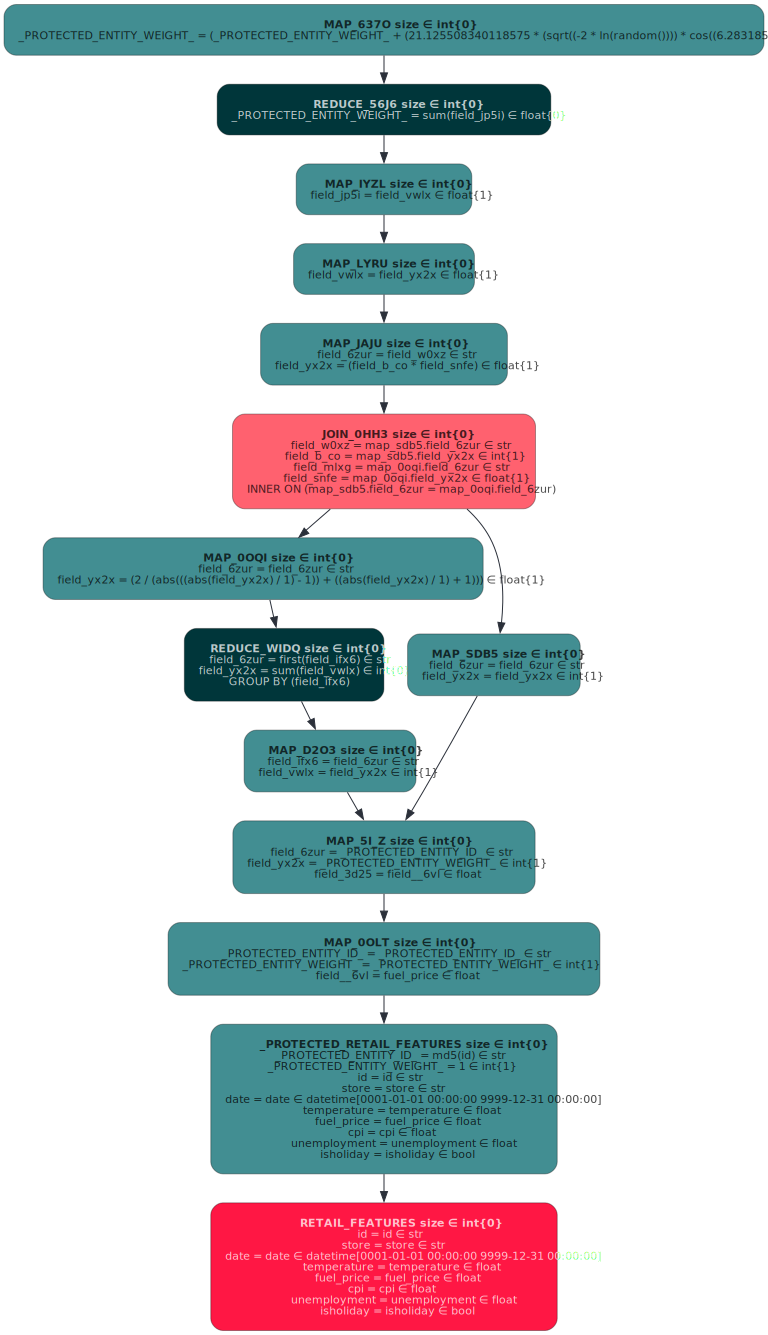

In [40]:
display(graphviz.Source(dp_relation.dot()))

In [47]:
print_query(dp_relation.render())

WITH
  _PROTECTED_retail_features (_PROTECTED_ENTITY_ID_, _PROTECTED_ENTITY_WEIGHT_, id, store, date, temperature, fuel_price, cpi, unemployment, isholiday) AS (SELECT md5(id) AS _PROTECTED_ENTITY_ID_, 1 AS _PROTECTED_ENTITY_WEIGHT_, id AS id, store AS store, date AS date, temperature AS temperature, fuel_price AS fuel_price, cpi AS cpi, unemployment AS unemployment, isholiday AS isholiday FROM retail.features),
  map_0olt (_PROTECTED_ENTITY_ID_, _PROTECTED_ENTITY_WEIGHT_, field__6vl) AS (SELECT _PROTECTED_ENTITY_ID_ AS _PROTECTED_ENTITY_ID_, _PROTECTED_ENTITY_WEIGHT_ AS _PROTECTED_ENTITY_WEIGHT_, fuel_price AS field__6vl FROM _PROTECTED_retail_features),
  map_5i_z (field_6zur, field_yx2x, field_3d25) AS (SELECT _PROTECTED_ENTITY_ID_ AS field_6zur, _PROTECTED_ENTITY_WEIGHT_ AS field_yx2x, field__6vl AS field_3d25 FROM map_0olt),
  map_sdb5 (field_6zur, field_yx2x) AS (SELECT field_6zur AS field_6zur, field_yx2x AS field_yx2x FROM map_5i_z),
  map_d2o3 (field_ifx6, field_vwlx) AS (SELE

In [46]:
true_res = pd.DataFrame(db.execute(query))
res = pd.DataFrame(db.eval(dp_relation))

print(f"Initial query:                         SUM(fuel_price): {true_res.iloc[0][0]}")
print("Sum over the all protected entities:   SUM(fuel_price): ", res["sum_fuel_pric"][0])

Initial query:                         SUM(fuel_price): 2965.1169999999997


KeyError: 'sum_fuel_pric'

In [48]:
true_value = true_res.iloc[0][0]
query = "SELECT SUM(fuel_price) AS my_sum FROM features"
data = run(dataset, query, [0.1, 1., 2.])

thread '<unnamed>' panicked at 'called `Result::unwrap()` on an `Err` value: InvalidField("_PROTECTED_ENTITY_ID_ is missing")', /Users/victoriadesainteagathe/.cargo/registry/src/github.com-1ecc6299db9ec823/qrlew-0.2.1/src/expr/mod.rs:891:12


PanicException: called `Result::unwrap()` on an `Err` value: InvalidField("_PROTECTED_ENTITY_ID_ is missing")

In [ ]:
plot_hist(true_value, data, query)